In [1]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

B2.1a

In [2]:
#set randan seed
torch.manual_seed(200205854)
#set batch size
batchSize = 4
#set transfrom
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])])

#Load the training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=False, num_workers=2)
#Load the test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print('Training set size:', len(trainset))
print('Test set size:',len(testset))

Training set size: 60000
Test set size: 10000


Ankle boot T-shirt/top T-shirt/top      Dress


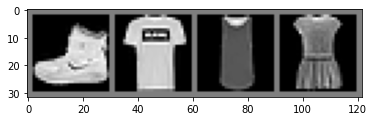

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap="gray") #rearrange dimensions to numpy format for disply
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() #Get one batch (4 here)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(batchSize)))

B2.2b

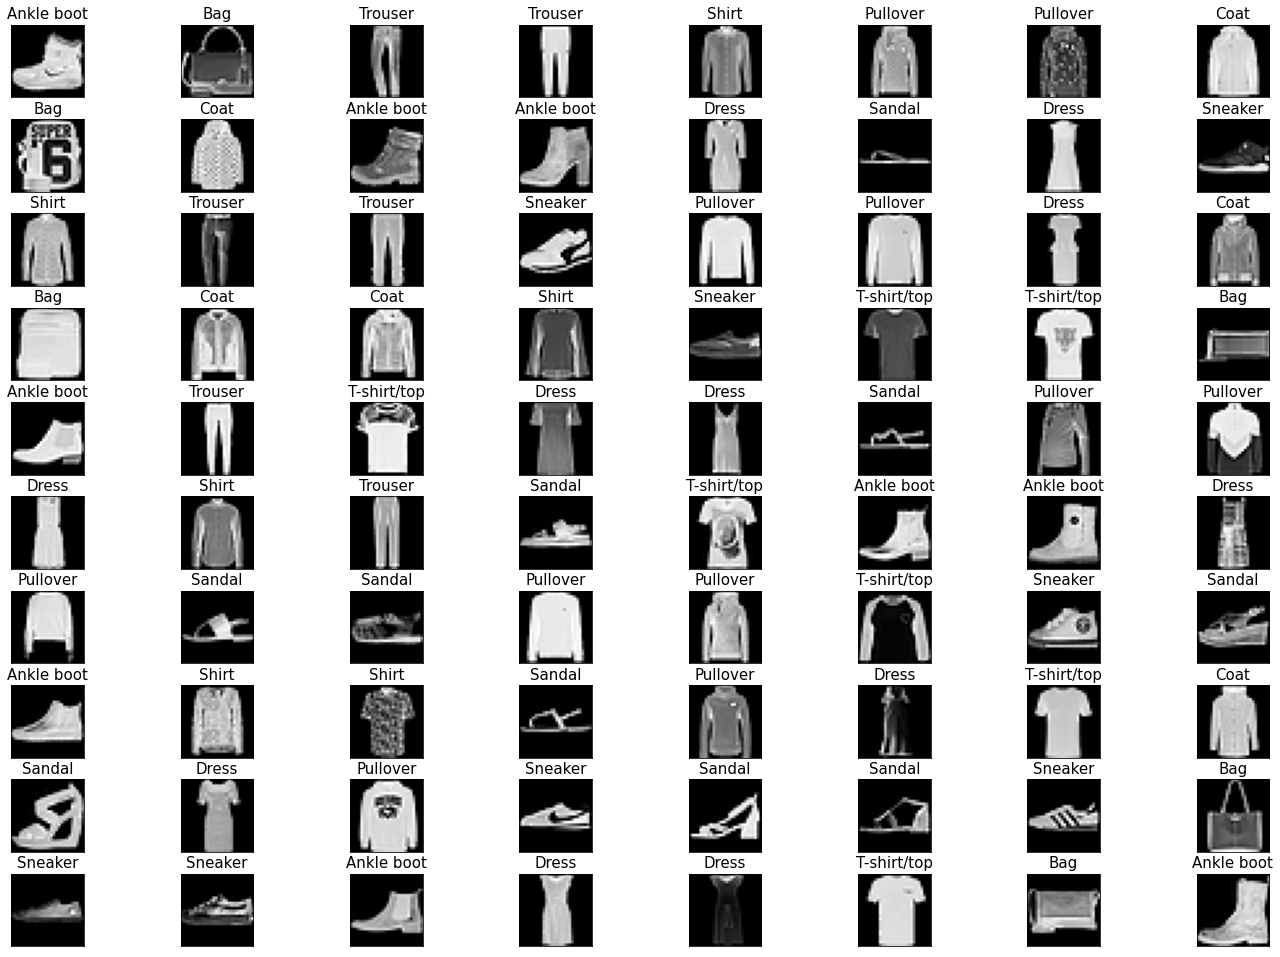

In [4]:
dataloader = torch.utils.data.DataLoader(trainset, batch_size=int(60000/80),
                                          shuffle=False, num_workers=2)
plt.subplots_adjust(left=0.5,
                    bottom=0.4, 
                    right=3.6, 
                    top=3.6, 
                    wspace=0.1, 
                    hspace=0.3)
def matplotlib_multi_pic1():
    i = 0
    for image, label in dataloader:
        i = i+1
        img = image[0]
        title=classes[label[0]]
        plt.subplot(10,8,i)
        imshow(img)
        plt.title(title,fontsize=15)
        plt.xticks([])
        plt.yticks([])
    plt.show()
matplotlib_multi_pic1()

B2.3

In [5]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(28*28,10)
        self.sm = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.lr(x)
        x = self.sm(x)
        return x

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(lr.parameters(), lr=0.005)

In [6]:
def train_lr_model(lr,b):
    max_epochs = 6
    #torch.cuda.synchronize()
    start = time.time()
    for epoch in range(max_epochs):
        running_loss = 0.0
        for i,(images, labels) in enumerate(trainloader):
            images = images
            labels = labels
            
            lr.zero_grad()
        
            output = criterion(lr(images), labels)
            l1_regularization, l2_regularization = torch.tensor([0], dtype=torch.float32), torch.tensor([0],dtype=torch.float32)  # 定义L1及L2正则化损失
            if(b == 'l1'):
                for param in lr.parameters():
                    l2_regularization += torch.norm(param,1)  # L1 正则化
                output = output + 10e-5 * l1_regularization
            elif(b == 'l2'):
                for param in lr.parameters():
                    l2_regularization += torch.norm(param,2)  # L2 正则化
                output = output + 10e-3 * l2_regularization
            elif(b == "n"):
                outpur = output
            loss =output.item()
        
            output.backward()
        
            # Apply gradients
            for param in lr.parameters():
                param.data.add_(-0.5 * param.grad.data)

            # Stop criterion
            if loss < 1e-3:
                break
            running_loss += loss
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    #torch.cuda.synchronize()
    end = time.time()
    print('training time %.2f' % (end-start))
    num_params = sum(x.numel() for x in lr.parameters())
    print("Total number of paramerters in LogristicRegression is {}".format(num_params))
    return (end-start), num_params

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    plt.title('confusion matrix', fontsize = 20)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=0.5,  cbar=True, ax=ax, cmap='Blues',square=True)
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [8]:
# test the model
def test_model(model):
    correct = 0
    total = 0
    y_pred = []
    y = []
    for images, labels in trainloader:
        images= images
        labels =labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy_in_trainset = (100 * correct / total)
    print('accuracy of the model on training dataset %.2f' % accuracy_in_trainset)
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted
        y += labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy_in_testset = (100 * correct / total)
    print('accuracy of the model on test dataset %.2f' % (100 * correct / total))
    plot_confusion_matrix(y_pred, y)
    return accuracy_in_trainset, accuracy_in_testset
    

[1,  2000] loss: 1.696306
[1,  4000] loss: 1.635811
[1,  6000] loss: 1.628519
[1,  8000] loss: 1.618514
[1, 10000] loss: 1.616330
[1, 12000] loss: 1.607580
[1, 14000] loss: 1.607276
[2,  2000] loss: 1.601963
[2,  4000] loss: 1.598242
[2,  6000] loss: 1.597904
[2,  8000] loss: 1.597735
[2, 10000] loss: 1.596331
[2, 12000] loss: 1.591597
[2, 14000] loss: 1.596116
[3,  2000] loss: 1.594149
[3,  4000] loss: 1.588292
[3,  6000] loss: 1.589226
[3,  8000] loss: 1.588254
[3, 10000] loss: 1.589110
[3, 12000] loss: 1.587514
[3, 14000] loss: 1.590827
[4,  2000] loss: 1.586707
[4,  4000] loss: 1.586139
[4,  6000] loss: 1.585651
[4,  8000] loss: 1.583573
[4, 10000] loss: 1.581473
[4, 12000] loss: 1.583045
[4, 14000] loss: 1.584928
[5,  2000] loss: 1.584433
[5,  4000] loss: 1.583036
[5,  6000] loss: 1.581438
[5,  8000] loss: 1.581235
[5, 10000] loss: 1.581761
[5, 12000] loss: 1.578996
[5, 14000] loss: 1.581560
[6,  2000] loss: 1.582205
[6,  4000] loss: 1.579098
[6,  6000] loss: 1.580255
[6,  8000] l

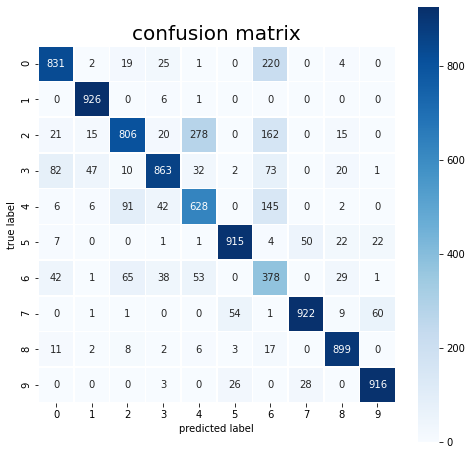

In [9]:
lr1 = LogisticRegression()
time_lr1, num_params_lr1 = train_lr_model(lr1,'n') # no regularization
accuracy_trainset_lr1, accuracy_testset_lr1 = test_model(lr1)

[1,  2000] loss: 1.698299
[1,  4000] loss: 1.638937
[1,  6000] loss: 1.631854
[1,  8000] loss: 1.617404
[1, 10000] loss: 1.614383
[1, 12000] loss: 1.607679
[1, 14000] loss: 1.606922
[2,  2000] loss: 1.600285
[2,  4000] loss: 1.598505
[2,  6000] loss: 1.599023
[2,  8000] loss: 1.596952
[2, 10000] loss: 1.595672
[2, 12000] loss: 1.591604
[2, 14000] loss: 1.597548
[3,  2000] loss: 1.592430
[3,  4000] loss: 1.591099
[3,  6000] loss: 1.589386
[3,  8000] loss: 1.588220
[3, 10000] loss: 1.591314
[3, 12000] loss: 1.585737
[3, 14000] loss: 1.588756
[4,  2000] loss: 1.586772
[4,  4000] loss: 1.584853
[4,  6000] loss: 1.586461
[4,  8000] loss: 1.584725
[4, 10000] loss: 1.585803
[4, 12000] loss: 1.581710
[4, 14000] loss: 1.584537
[5,  2000] loss: 1.585374
[5,  4000] loss: 1.582287
[5,  6000] loss: 1.579804
[5,  8000] loss: 1.580523
[5, 10000] loss: 1.583270
[5, 12000] loss: 1.583047
[5, 14000] loss: 1.583711
[6,  2000] loss: 1.583157
[6,  4000] loss: 1.578651
[6,  6000] loss: 1.579387
[6,  8000] l

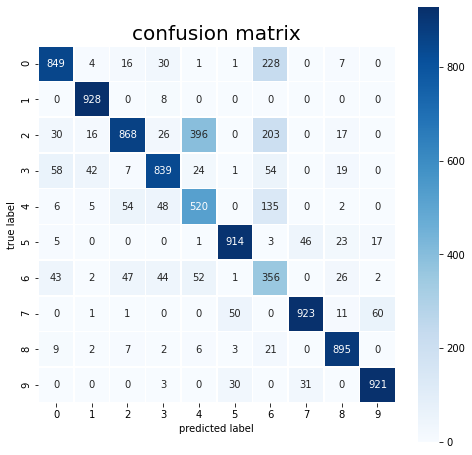

In [10]:
lr2 = LogisticRegression()
time_lr2, num_params_lr2 = train_lr_model(lr2, 'l1') # l1_regularization
accuracy_trainset_lr2, accuracy_testset_lr2 = test_model(lr2)

[1,  2000] loss: 1.785343
[1,  4000] loss: 1.756862
[1,  6000] loss: 1.761907
[1,  8000] loss: 1.757666
[1, 10000] loss: 1.759182
[1, 12000] loss: 1.755243
[1, 14000] loss: 1.755566
[2,  2000] loss: 1.757130
[2,  4000] loss: 1.753853
[2,  6000] loss: 1.761556
[2,  8000] loss: 1.756642
[2, 10000] loss: 1.759057
[2, 12000] loss: 1.754721
[2, 14000] loss: 1.757501
[3,  2000] loss: 1.757893
[3,  4000] loss: 1.754416
[3,  6000] loss: 1.758672
[3,  8000] loss: 1.759781
[3, 10000] loss: 1.759245
[3, 12000] loss: 1.754786
[3, 14000] loss: 1.755115
[4,  2000] loss: 1.756528
[4,  4000] loss: 1.755281
[4,  6000] loss: 1.759952
[4,  8000] loss: 1.756809
[4, 10000] loss: 1.757397
[4, 12000] loss: 1.757089
[4, 14000] loss: 1.757276
[5,  2000] loss: 1.755163
[5,  4000] loss: 1.752322
[5,  6000] loss: 1.760058
[5,  8000] loss: 1.758458
[5, 10000] loss: 1.758954
[5, 12000] loss: 1.753183
[5, 14000] loss: 1.757356
[6,  2000] loss: 1.757733
[6,  4000] loss: 1.756569
[6,  6000] loss: 1.760940
[6,  8000] l

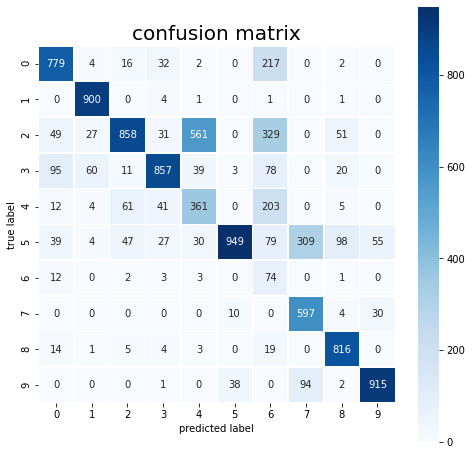

In [11]:
lr3 = LogisticRegression()
time_lr3, num_params_lr3 = train_lr_model(lr3,'l2') # l2_regularization
accuracy_trainset_lr3, accuracy_testset_lr3 = test_model(lr3)

B2.4

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

myCNN = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN.parameters(), lr=0.01, momentum=0.5)

In [13]:
def train_cnn(model):
    max_epochs=6
    start=time.time()
    for epoch in range(max_epochs):  # loop over the dataset multiple times

        optimizer.zero_grad()
        running_loss = 0.0 
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches 
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    end = time.time()
    print('Finished Training!') 
    print('training time %.2f' % (end-start))
    num_params = sum(x.numel() for x in model.parameters())
    print("Total number of paramerters in cnn is {}".format(num_params))
    return (end-start), num_params

[1,  2000] loss: 0.847
[1,  4000] loss: 0.559
[1,  6000] loss: 0.486
[1,  8000] loss: 0.440
[1, 10000] loss: 0.414
[1, 12000] loss: 0.400
[1, 14000] loss: 0.383
[2,  2000] loss: 0.363
[2,  4000] loss: 0.355
[2,  6000] loss: 0.351
[2,  8000] loss: 0.339
[2, 10000] loss: 0.337
[2, 12000] loss: 0.338
[2, 14000] loss: 0.327
[3,  2000] loss: 0.311
[3,  4000] loss: 0.314
[3,  6000] loss: 0.314
[3,  8000] loss: 0.303
[3, 10000] loss: 0.309
[3, 12000] loss: 0.312
[3, 14000] loss: 0.302
[4,  2000] loss: 0.286
[4,  4000] loss: 0.288
[4,  6000] loss: 0.290
[4,  8000] loss: 0.287
[4, 10000] loss: 0.283
[4, 12000] loss: 0.293
[4, 14000] loss: 0.288
[5,  2000] loss: 0.271
[5,  4000] loss: 0.277
[5,  6000] loss: 0.278
[5,  8000] loss: 0.271
[5, 10000] loss: 0.268
[5, 12000] loss: 0.276
[5, 14000] loss: 0.271
[6,  2000] loss: 0.258
[6,  4000] loss: 0.259
[6,  6000] loss: 0.269
[6,  8000] loss: 0.260
[6, 10000] loss: 0.258
[6, 12000] loss: 0.270
[6, 14000] loss: 0.265
Finished Training!
training time 2

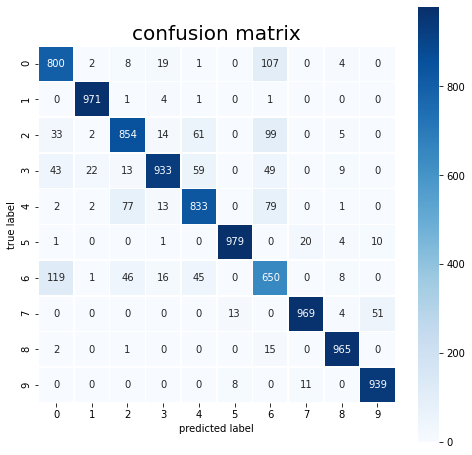

In [14]:
time_cnn1, num_params_cnn1 = train_cnn(myCNN)
accuracy_trainset_cnn1, accuracy_testset_cnn1 = test_model(myCNN)

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 20)
        self.fc5 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

myCNN2 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN2.parameters(), lr=0.01, momentum=0.5)

In [16]:
time_cnn2, num_params_cnn2 = train_cnn(myCNN2)

[1,  2000] loss: 2.087
[1,  4000] loss: 0.879
[1,  6000] loss: 0.646
[1,  8000] loss: 0.568
[1, 10000] loss: 0.525
[1, 12000] loss: 0.502
[1, 14000] loss: 0.477
[2,  2000] loss: 0.439
[2,  4000] loss: 0.423
[2,  6000] loss: 0.402
[2,  8000] loss: 0.383
[2, 10000] loss: 0.369
[2, 12000] loss: 0.364
[2, 14000] loss: 0.359
[3,  2000] loss: 0.347
[3,  4000] loss: 0.337
[3,  6000] loss: 0.336
[3,  8000] loss: 0.328
[3, 10000] loss: 0.321
[3, 12000] loss: 0.319
[3, 14000] loss: 0.313
[4,  2000] loss: 0.311
[4,  4000] loss: 0.301
[4,  6000] loss: 0.303
[4,  8000] loss: 0.297
[4, 10000] loss: 0.295
[4, 12000] loss: 0.286
[4, 14000] loss: 0.291
[5,  2000] loss: 0.280
[5,  4000] loss: 0.280
[5,  6000] loss: 0.275
[5,  8000] loss: 0.272
[5, 10000] loss: 0.271
[5, 12000] loss: 0.264
[5, 14000] loss: 0.266
[6,  2000] loss: 0.263
[6,  4000] loss: 0.265
[6,  6000] loss: 0.269
[6,  8000] loss: 0.258
[6, 10000] loss: 0.263
[6, 12000] loss: 0.251
[6, 14000] loss: 0.261
Finished Training!
training time 3

accuracy of the model on training dataset 90.40
accuracy of the model on test dataset 88.28


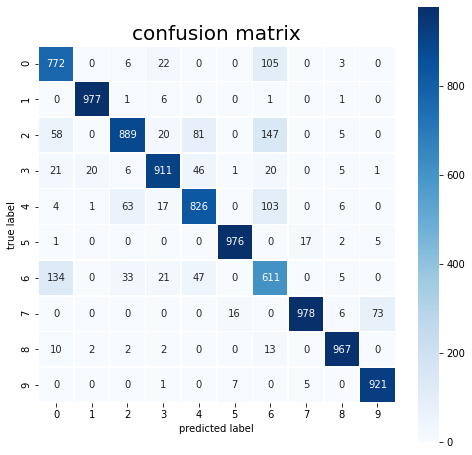

In [17]:
accuracy_trainset_cnn2, accuracy_testset_cnn2 = test_model(myCNN2)

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10,15, 5)
        self.conv4 = nn.Conv2d(15,20, 5)
        self.conv5 = nn.Conv2d(20,25, 5)
        self.fc1 = nn.Linear(25*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 25*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

myCNN3 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN3.parameters(), lr=0.01, momentum=0.5)

In [19]:
time_cnn3, num_params_cnn3 = train_cnn(myCNN3)

[1,  2000] loss: 1.519
[1,  4000] loss: 0.791
[1,  6000] loss: 0.682
[1,  8000] loss: 0.614
[1, 10000] loss: 0.567
[1, 12000] loss: 0.543
[1, 14000] loss: 0.510
[2,  2000] loss: 0.480
[2,  4000] loss: 0.479
[2,  6000] loss: 0.470
[2,  8000] loss: 0.442
[2, 10000] loss: 0.429
[2, 12000] loss: 0.426
[2, 14000] loss: 0.413
[3,  2000] loss: 0.396
[3,  4000] loss: 0.401
[3,  6000] loss: 0.397
[3,  8000] loss: 0.379
[3, 10000] loss: 0.374
[3, 12000] loss: 0.380
[3, 14000] loss: 0.367
[4,  2000] loss: 0.358
[4,  4000] loss: 0.367
[4,  6000] loss: 0.377
[4,  8000] loss: 0.348
[4, 10000] loss: 0.351
[4, 12000] loss: 0.362
[4, 14000] loss: 0.350
[5,  2000] loss: 0.331
[5,  4000] loss: 0.341
[5,  6000] loss: 0.350
[5,  8000] loss: 0.333
[5, 10000] loss: 0.328
[5, 12000] loss: 0.343
[5, 14000] loss: 0.335
[6,  2000] loss: 0.326
[6,  4000] loss: 0.335
[6,  6000] loss: 0.337
[6,  8000] loss: 0.320
[6, 10000] loss: 0.325
[6, 12000] loss: 0.332
[6, 14000] loss: 0.334
Finished Training!
training time 5

accuracy of the model on training dataset 88.64
accuracy of the model on test dataset 87.10


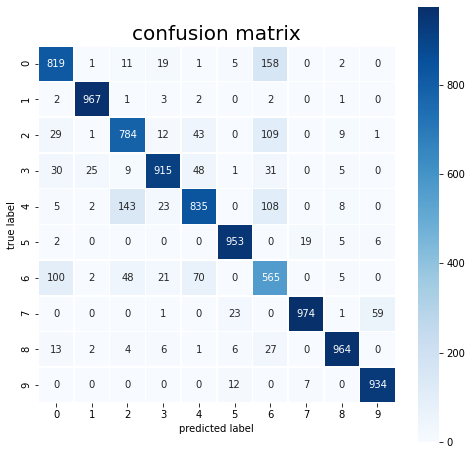

In [20]:
accuracy_trainset_cnn3, accuracy_testset_cnn3 = test_model(myCNN3)

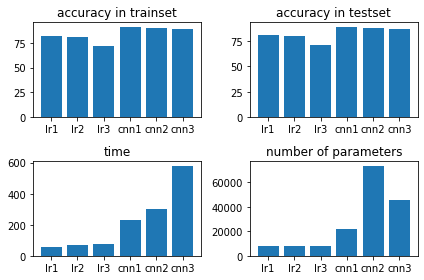

In [21]:
name_list = ['lr1', 'lr2', 'lr3', 'cnn1', 'cnn2', 'cnn3']
time_list = [time_lr1, time_lr2, time_lr3, time_cnn1, time_cnn2, time_cnn3]
params_list = [num_params_lr1, num_params_lr2, num_params_lr3, num_params_cnn1, num_params_cnn2, num_params_cnn3]
accuracy_trainset_list = [accuracy_trainset_lr1, accuracy_trainset_lr2, accuracy_trainset_lr3,
                         accuracy_trainset_cnn1, accuracy_trainset_cnn2, accuracy_trainset_cnn3]
accuracy_testset_list = [accuracy_testset_lr1, accuracy_testset_lr2, accuracy_testset_lr3, accuracy_testset_cnn1,
                        accuracy_testset_cnn2, accuracy_testset_cnn3]

fig=plt.figure()
ax1 = fig.add_subplot(221)
ax1.bar(range(len(accuracy_trainset_list)), accuracy_trainset_list, tick_label=name_list)
ax1.set_title('accuracy in trainset')

ax2 = fig.add_subplot(222)
ax2.bar(range(len(accuracy_testset_list)), accuracy_testset_list, tick_label = name_list)
ax2.set_title('accuracy in testset')

ax3 = fig.add_subplot(223)
ax3.bar(range(len(time_list)), time_list, tick_label = name_list)
ax3.set_title('time')

ax4 = fig.add_subplot(224)
ax4.bar(range(len(params_list)), params_list, tick_label = name_list)
ax4.set_title('number of parameters')

fig.tight_layout() 

The more hidden layers of the neural network, the result is not necessarily better.
Select the appropriate neural network structure is very important.

B3.1

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [23]:
dataset = []
for data in trainset:
    if(data[1] == 0 or data[1] == 9):
        dataset.append(data)

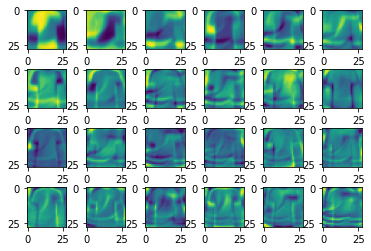

In [24]:
X = np.array(dataset[:][0][0].numpy()).reshape(1, 28*28)
for i in range(1, len(dataset[:])):
    X = np.append(X,np.array(dataset[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=0.95) # save 24 eigenvectors 
pca.fit(X)
cov_matrix = np.dot(X.T, X) / len(X)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.5)
for i,eigenvector in enumerate(pca.components_[:24]):
    i = i + 1
    plt.subplot(4,6,i)
    plt.imshow(eigenvector.reshape(28,28))

In [25]:
def reconstrcut_30_images(n):
    num_class = 0
    print(classes[n]+':\n')
    for data in dataset:
        images = np.array(data[0][0])
        labels = data[1]
        if(num_class == 15):
            break
        if(labels == n):
            plt.figure(figsize=(30,30))
            plt.subplot(15,8,num_class*8+1)
            plt.imshow(images)
            lowDmat = np.dot(images.reshape(1,28*28), pca.components_[0:24].T)
            reconMat = np.dot(lowDmat,pca.components_[:24])
            plt.subplot(15,8,num_class*8+2)
            plt.imshow(reconMat.reshape(28,28))
            print(mean_squared_error(images.reshape(1,28*28), reconMat))
            num_class += 1

T-shirt/top:

0.1425582
0.09513537
0.18359223
0.087050945
0.09218981
0.20811214
0.09647146
0.103574805
0.13285495
0.15031298
0.080582164
0.1604559
0.22549656
0.116071194
0.071279466


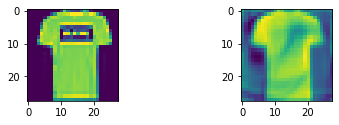

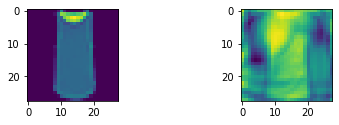

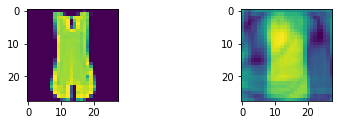

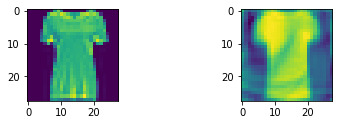

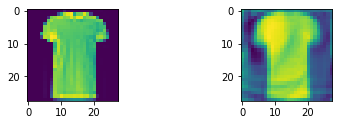

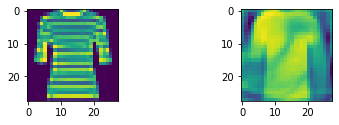

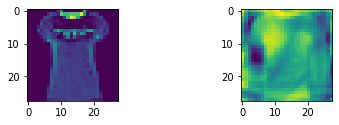

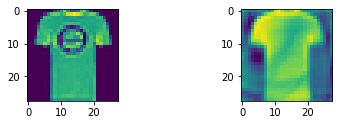

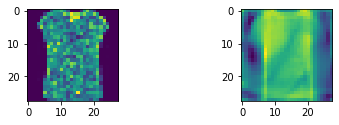

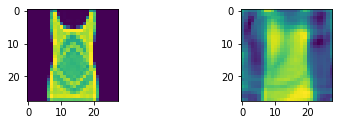

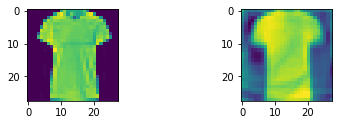

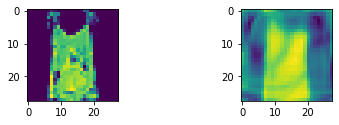

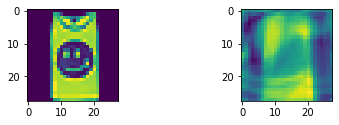

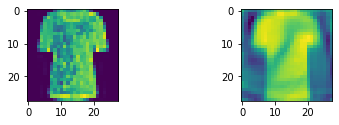

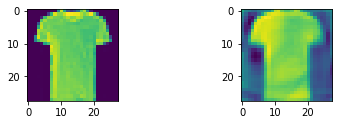

In [26]:
reconstrcut_30_images(0)

Ankle boot:

0.15877528
0.2858416
0.12644985
0.10199389
0.2762006
0.21141414
0.18191095
0.18848139
0.12384759
0.1253338
0.12527992
0.10444021
0.10159897
0.11311706
0.24180742


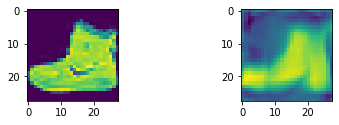

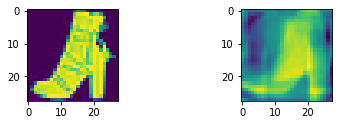

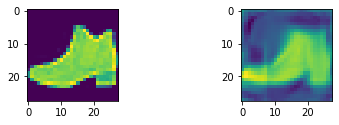

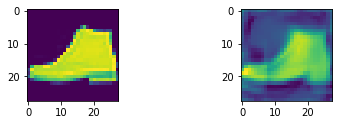

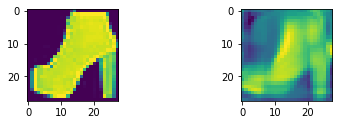

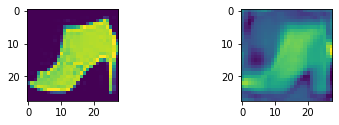

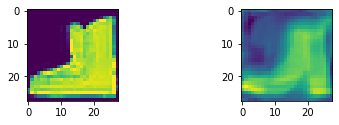

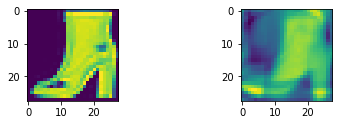

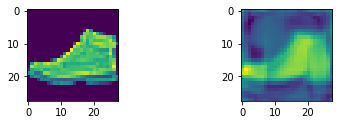

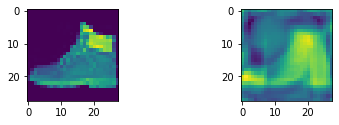

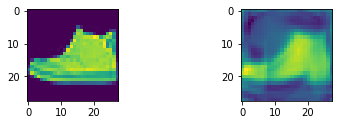

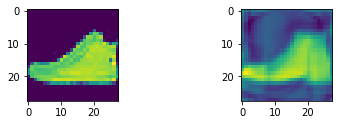

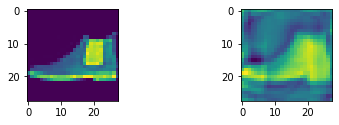

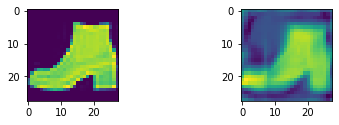

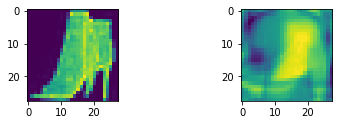

In [27]:
reconstrcut_30_images(9)

In [28]:
data_class_0 = []
data_class_9 = []
for data in dataset:
    images = np.array(data[0][0])
    labels = data[1]
    if(labels == 0):
        data_class_0.append(np.dot(images.reshape(28*28),pca.components_[0:2].T))
    elif(labels == 9):
        data_class_9.append(np.dot(images.reshape(28*28),pca.components_[0:2].T))

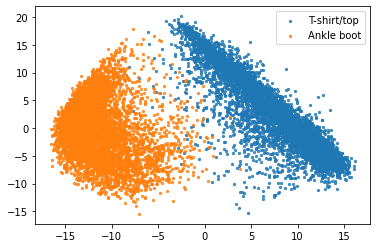

In [29]:
plt.scatter(pd.DataFrame(data_class_0)[:][0],pd.DataFrame(data_class_0)[:][1],s=5,alpha=0.8)
plt.scatter(pd.DataFrame(data_class_9)[:][0],pd.DataFrame(data_class_9)[:][1],s=5,alpha=0.8)
plt.legend([classes[0],classes[9]])
plt.show()

In [30]:
all_data = np.array(data_class_9 + data_class_0)

estimator = KMeans(n_clusters=2)
estimator.fit(all_data)
label_pred = estimator.labels_ 
centroids = estimator.cluster_centers_ 
inertia = estimator.inertia_

In [31]:
data_class_0 = []
data_class_9 = []
for i in range(0,len(all_data)):
    if(label_pred[i] == 0):
        data_class_0.append(all_data[i])
    elif(label_pred[i] == 1):
        data_class_9.append(all_data[i])

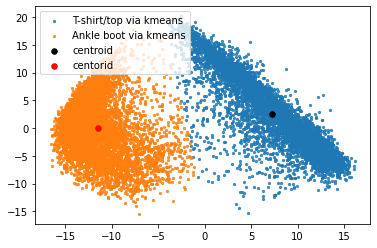

In [32]:
plt.scatter(pd.DataFrame(data_class_0)[:][0],pd.DataFrame(data_class_0)[:][1],s=5,alpha=0.8)
plt.scatter(pd.DataFrame(data_class_9)[:][0],pd.DataFrame(data_class_9)[:][1],s=5,alpha=0.8)
plt.scatter(centroids[0][0],centroids[0][1], s = 30, c ='k')
plt.scatter(centroids[1][0],centroids[1][1], s = 30, c ='r')
plt.legend([classes[0]+' via kmeans',classes[9]+' via kmeans', 'centroid','centorid'])
plt.show()

B3.2

In [807]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 2, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2,stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [810]:
myAE=Autoencoder().cuda()
#Training (optimisation) parameters
batch_size=60
learning_rate=1e-3
max_epochs = 20

#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_rate, weight_decay=1e-5)
#Specify how the data will be loaded in batches (with random shuffling)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [811]:
#Start training
all_loss = []
outputs = []
for epoch in range(max_epochs):
    for data in train_loader:
        img, label = data
        optimizer.zero_grad()
        recon = myAE(img.cuda())
        loss = criterion(recon, img.cuda())
        loss.backward()
        optimizer.step()            
    print('Epoch:{}, Loss:{:.4f}'.format(epoch, float(loss)))
    all_loss.append(float(loss))
    outputs.append((epoch, img, recon),)

Epoch:0, Loss:0.6613
Epoch:1, Loss:0.5897
Epoch:2, Loss:0.5703
Epoch:3, Loss:0.5800
Epoch:4, Loss:0.5626
Epoch:5, Loss:0.5565
Epoch:6, Loss:0.5734
Epoch:7, Loss:0.5602
Epoch:8, Loss:0.5425
Epoch:9, Loss:0.5589
Epoch:10, Loss:0.5858
Epoch:11, Loss:0.5554
Epoch:12, Loss:0.5459
Epoch:13, Loss:0.5437
Epoch:14, Loss:0.5525
Epoch:15, Loss:0.5589
Epoch:16, Loss:0.5462
Epoch:17, Loss:0.5674
Epoch:18, Loss:0.5434
Epoch:19, Loss:0.5498


Epoch: 1
Epoch: 10
Epoch: 19


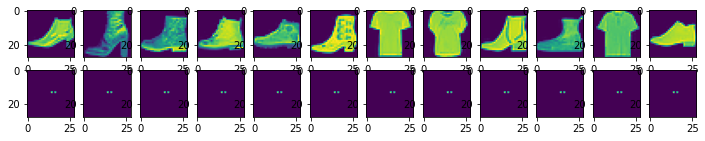

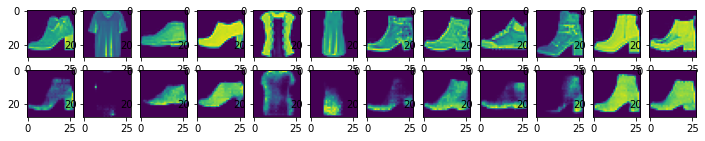

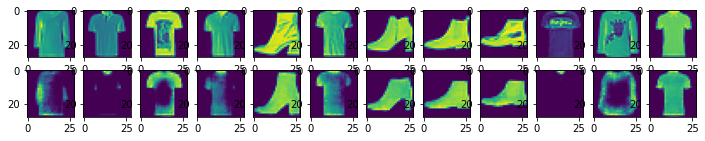

In [812]:
numImgs=12;
for k in range(0, max_epochs, 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.imshow(item[0])

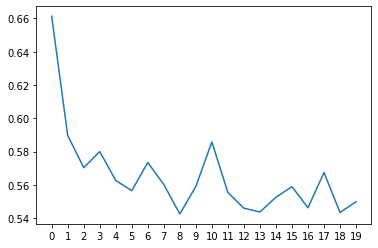

In [813]:
x_list = range(0,20)
plt.xticks(np.arange(0,20,1))
plt.plot(x_list,all_loss)
plt.show()

In [970]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(True),
            nn.Linear(128,10),
            nn.ReLU(True),
            nn.Linear(10,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,10),
            nn.ReLU(True),
            nn.Linear(10,128),
            nn.ReLU(True),
            nn.Linear(128,28*28),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return encoder,decoder

In [971]:
myAE2=Autoencoder().cuda()
optimizer = torch.optim.Adam(myAE2.parameters(), lr=1e-2)
#Start training
all_loss = []
outputs = []
for epoch in range(max_epochs):
    for data in train_loader:
        img, label = data
        img = img.view(batch_size,-1)
        optimizer.zero_grad()
        _,recon = myAE2(img.cuda())
        img = img.view(batch_size,1,28,28)
        recon = recon.view(batch_size,1,28,28)
        loss = criterion(recon, img.cuda())
        loss.backward()
        optimizer.step()            
    print('Epoch:{}, Loss:{:.4f}'.format(epoch, float(loss)))
    all_loss.append(float(loss))
    outputs.append((epoch, img, recon),)

Epoch:0, Loss:0.6668
Epoch:1, Loss:0.5872
Epoch:2, Loss:0.5934
Epoch:3, Loss:0.6007
Epoch:4, Loss:0.5741
Epoch:5, Loss:0.5916
Epoch:6, Loss:0.6052
Epoch:7, Loss:0.5729
Epoch:8, Loss:0.5859
Epoch:9, Loss:0.5942
Epoch:10, Loss:0.5819
Epoch:11, Loss:0.5858
Epoch:12, Loss:0.5797
Epoch:13, Loss:0.5744
Epoch:14, Loss:0.5881
Epoch:15, Loss:0.5681
Epoch:16, Loss:0.5548
Epoch:17, Loss:0.5764
Epoch:18, Loss:0.5576
Epoch:19, Loss:0.5816


In [972]:
data_class_0 = []
data_class_9 = []
for data in train_loader:
    img, label = data
    i = 0
    for im in img:
        im=im.view(-1,28*28)
        if(label[i] == 0):
            x,_ = myAE2(im.cuda())
            data_class_0.append(x[0].cpu().detach().numpy())
        elif(label[i] == 9):
            x,_ = myAE2(im.cuda())
            data_class_9.append(x[0].cpu().detach().numpy())
        i+=1

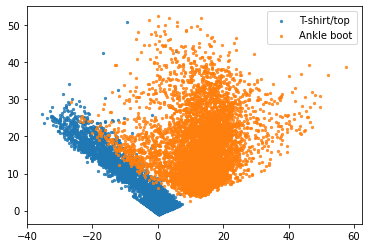

In [973]:
plt.scatter(pd.DataFrame(data_class_0)[:][0],pd.DataFrame(data_class_0)[:][1],s=5,alpha=0.8)
plt.scatter(pd.DataFrame(data_class_9)[:][0],pd.DataFrame(data_class_9)[:][1],s=5,alpha=0.8)
plt.legend([classes[0],classes[9]])
plt.show()

In [974]:
all_data = np.array(data_class_9 + data_class_0)

estimator = KMeans(n_clusters=2)
estimator.fit(all_data)
label_pred = estimator.labels_ 
centroids = estimator.cluster_centers_ 
inertia = estimator.inertia_

In [975]:
data_class_0 = []
data_class_9 = []
for i in range(0,len(all_data)):
    if(label_pred[i] == 0):
        data_class_0.append(all_data[i])
    elif(label_pred[i] == 1):
        data_class_9.append(all_data[i])

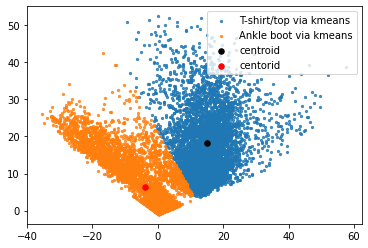

In [976]:
plt.scatter(pd.DataFrame(data_class_0)[:][0],pd.DataFrame(data_class_0)[:][1],s=5,alpha=0.8)
plt.scatter(pd.DataFrame(data_class_9)[:][0],pd.DataFrame(data_class_9)[:][1],s=5,alpha=0.8)
plt.scatter(centroids[0][0],centroids[0][1], s = 30, c ='k')
plt.scatter(centroids[1][0],centroids[1][1], s = 30, c ='r')
plt.legend([classes[0]+' via kmeans',classes[9]+' via kmeans', 'centroid','centorid'])
plt.show()

B3.3
1 PCA does not require a lot of data to get better results, while neural networks need more data. 
2 The kmean algorithm has a certain degree of randomness.